# Выпускной проект. Банк - Анализ оттока клиентов.

**Описание проекта**: В банке "Метанпром" резко вырос отток клиентов, что стало серьезной проблемой и может угрожать существованию бизнеса.

**Цель исследования**: Выделить сегменты отточных клиентов: однородные, высокотточные и покрывающие максимальное число проблемных зон банка.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в 
Ярославле и областных городах: Ростов Великий и Рыбинск.
 **Данные**:
- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity  — количество баллов собственности
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — активный клиент,
- EST_SALARY — оценочный доход клиента,
- сhurn — признак оттока

Представленный датасет содержит набор категоральных и количественных показателей по физическим лицам-клиентам банка в трёх городах.

**Содержание проекта**:

1. [Загрузка и изучение общей информации](#initializing)
2. [Предобработка данных.](#preprocessing)
    * [Обработка пропущенных значений.](#null)
    * [Обработка дубликатов.](#duplicates)
3. [Исследовательский анализ данных](#analysis)
    * [Анализ баллов кредитного рейтинга. ](#ball)
    * [Анализ распределения клиентов по городам.](#city)
    * [Распределение клиентов по полу.](#gender)
    * [Распределение клиентов по возрасту.](#age)
    * [Распределение клиентов по баллам собственности.](#equity)
    * [Распределение клиентов по остатку на текущем счете.](#balance)
    * [Распределение клиентов по количеству подключенных продуктов банка.](#products)
    * [Распределение пользователей по наличию кредитных карт.](#credit)
    * [Распределение активных и неактивных клиентов.](#activity)
    * [Распределение клиентов по оценочному доходу. ](#salary)
    * [Корреляционный анализ данных.](#corr)
4. [Проверка гипотез.](#hyp)
    * [Гипотеза о наличии различия между доходами отточных клиентов и оставшихся.](#hyp_1)
    * [ Гипотеза о наличии связи между открытыми продуктами и признаком оттока.](#hyp_2)
5. [Формирование сегментов клиентов и их анализ.](#seg)
6. [Вывод](#conclusion)

## Загрузка и изучение общей информации. <a id="initializing"></a> 

In [1]:
# Импортируем библиотеки
import os
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats 

In [2]:
# Загружаем датасет
data_files = '/datasets/'
csv_name = 'bank_scrooge.csv'
try:
    df = pd.read_csv(f'{data_files}{csv_name}')
except:
    print('error')

In [3]:
# Выведем первый 5 строк датасета
pd.set_option('display.max_columns', None)
df.head()

USERID  score       city gender   age  equity     balance  products  \
0  183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1  146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2  120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3  225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4  157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  EST_SALARY  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

In [4]:
# Приведем названия колонок к нижнему регистру
df.columns = map(str.lower, df.columns)
df = df.rename(columns={'userid': 'user_id'})

In [5]:
# Скорректируем типы данных
df['credit_card'] = df['credit_card'].astype('bool')
df['last_activity'] = df['last_activity'].astype('bool')
df['churn'] = df['churn'].astype('bool')

In [6]:
# Выведем общую информацию по столбцам
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  bool   
 9   last_activity  10000 non-null  bool   
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  bool   
dtypes: bool(3), float64(4), int64(3), object(2)
memory usage: 732.5+ KB


В датасете имеется 10000 строк, типы данных столбцов credit_card, last_activity и churn приведены к булевым. В столбцах age и balance имеются пропуски. Необходимо изучить пропуски и проверить данные на наличие дубликатов.

## Предобработка данных. <a id="preprocessing"></a> 

### Обработка пропущенных значений. <a id="null"></a> 

In [7]:
# Выведем столбцы с пропущенным знаением возраста
missing_age= df[df['age'].isna()]
display(missing_age)
print('количество строк с NaN в cтолцбе age:', missing_age['user_id'].count(), 
      '\n', '% от общего числа строк:', (missing_age['user_id'].count()/10000)*100)

user_id  score       city gender  age  equity     balance  products  \
1247   228075  932.0  Ярославль      М  NaN       5  7601719.20         2   
2165   187635  692.0    Рыбинск      Ж  NaN       0         NaN         1   
2444   221156  913.0  Ярославль      М  NaN       0         NaN         1   
3091   138660  836.0     Ростов      Ж  NaN       5   294315.53         2   
4912   210674  834.0    Рыбинск      М  NaN       1   238330.52         2   
5470   218868  827.0    Рыбинск      Ж  NaN       4   448959.07         2   
5495   151662  884.0    Рыбинск      Ж  NaN       0         NaN         1   
7236   210135  908.0    Рыбинск      Ж  NaN       4  1120340.31         3   
7248   219343  920.0    Рыбинск      Ж  NaN       0         NaN         1   
7345   184913  829.0  Ярославль      Ж  NaN       3   188648.77         2   
7409   214031  777.0  Ярославль      М  NaN       2   171510.23         1   
8015   198635  670.0  Ярославль      Ж  NaN       0         NaN         1   
8070   226550  940.0    Рыбинск      М  NaN       0         NaN         1   
8293   216848  930.0  Ярославль      М  NaN       0         NaN         1   
8385   206759  915.0    Рыбинск      М  NaN       0         NaN         1   
8449   210898  805.0  Ярославль      Ж  NaN       0         NaN         1   
8632   221197  893.0  Ярославль      М  NaN       0         NaN         1   
8785   127440  663.0  Ярославль      М  NaN       0         NaN         1   
9104   222480  776.0    Рыбинск      Ж  NaN       5   796735.09         1   
9301   202983  942.0    Рыбинск      Ж  NaN       0         NaN         1   
9380   187459  894.0    Рыбинск      М  NaN       0         NaN         1   
9457   141945  929.0  Ярославль      М  NaN       0         NaN         1   
9632   185829  927.0  Ярославль      М  NaN       0         NaN         1   
9634   221809  917.0  Ярославль      М  NaN       0         NaN         1   
9667   163657  849.0  Ярославль      М  NaN       4  1254013.85         2   
9819   140934  832.0    Рыбинск      Ж  NaN       3   385763.16         2   

      credit_card  last_activity  est_salary  churn  
1247         True           True   408121.16  False  
2165         True           True   160368.82  False  
2444         True           True   135693.24  False  
3091        False           True    63310.22   True  
4912        False           True    93775.06  False  
5470         True           True    67835.95  False  
5495         True           True   137500.77  False  
7236         True           True    85002.15  False  
7248         True          False   159248.67  False  
7345        False           True    75206.90  False  
7409         True           True    75409.63  False  
8015         True           True   168699.33  False  
8070        False           True   147696.95  False  
8293         True           True   199542.51  False  
8385         True          False    71179.53  False  
8449        False           True   922080.25  False  
8632         True          False   173929.92  False  
8785         True           True   117197.56  False  
9104         True           True    55073.63  False  
9301         True           True   163804.73  False  
9380         True          False   178012.28  False  
9457         True          False   381868.89  False  
9632         True          False   231254.86  False  
9634         True           True   192644.15  False  
9667         True           True   119106.67  False  
9819        False           True    59651.35  False

количество строк с NaN в cтолцбе age: 26 
 % от общего числа строк: 0.26


Так как пропущенные значения составляют 0.26% от датасета, целесообразно заменить их на медиану.

In [8]:
# Удалим данные строчки
df['age'] = df['age'].dropna()

<div class="alert alert-info"> <b>Комментарий студента:</b> Удалил вместо замены на медиану. ✅ </div>

In [9]:
# Посчитаем количество проущенных строк в столбце balance
print('количество строк с NaN в cтолцбе age:', df['balance'].isna().sum(), 
      '\n', '% от общего числа строк:', (df['balance'].isna().sum()/10000)*100)

количество строк с NaN в cтолцбе age: 2295 
 % от общего числа строк: 22.95


Число пропущенных значений в столбце balance составляет 22,95% от всего датасета. Установить, является это нулевым балансом на текущем счете или просто ошибкой не представляется возможным, оставляем как есть.

In [10]:
balance_query = df[df['balance'].isna()].sort_values(by='user_id')
balance_query

user_id  score       city gender   age  equity  balance  products  \
1834   114182  890.0    Рыбинск      М  32.0       0      NaN         1   
4025   114196  915.0    Рыбинск      М  31.0       0      NaN         1   
4580   114209  892.0  Ярославль      Ж  29.0       0      NaN         1   
3980   114347  703.0  Ярославль      Ж  33.0       0      NaN         1   
7017   114422  708.0  Ярославль      Ж  69.0       0      NaN         1   
...       ...    ...        ...    ...   ...     ...      ...       ...   
8026   229036  948.0    Рыбинск      Ж  43.0       0      NaN         1   
3798   229050  899.0  Ярославль      Ж  40.0       0      NaN         1   
8622   229052  921.0    Рыбинск      М  42.0       0      NaN         1   
2373   229054  883.0  Ярославль      М  27.0       0      NaN         1   
8913   229145  698.0  Ярославль      Ж  37.0       0      NaN         1   

      credit_card  last_activity  est_salary  churn  
1834         True          False    82847.95  False  
4025         True           True   133324.89  False  
4580         True          False   120174.24  False  
3980         True          False   171038.71  False  
7017         True          False   159013.27  False  
...           ...            ...         ...    ...  
8026        False          False   241225.29  False  
3798        False          False   169445.35  False  
8622         True           True   221661.10  False  
2373         True           True   144948.73  False  
8913         True           True   255439.00  False  

[2295 rows x 12 columns]

In [11]:
display(balance_query['equity'].value_counts())
display(balance_query['products'].value_counts())
display(balance_query['churn'].value_counts())
display(balance_query['city'].value_counts())

0    2180
1     114
3       1
Name: equity, dtype: int64

1    1950
2     315
3      29
0       1
Name: products, dtype: int64

False    2282
True       13
Name: churn, dtype: int64

Ярославль    1467
Рыбинск       593
Ростов        235
Name: city, dtype: int64

In [12]:
display(balance_query['est_salary'].describe().round())

count       2295.0
mean      226310.0
std       199772.0
min        20274.0
25%       120348.0
50%       174161.0
75%       240015.0
max      1333687.0
Name: est_salary, dtype: float64

Рассмотрев данные по клиентам с нулевым текущем остатком на счете можно сделать несколько наблюдений:
- У клиентов низкий оценочный балл собственности - 1 или 0, т.е. они не обладают большим количеством активов.
- Большинство клиентов в этом датафрейме неотточные (отточных 12 записей).
- У большей части клиентов 1 или 2 банковских продукта.
- Оценочный доход в среднем выше, чем в целом по банку, но это мало о чем говорит.

Исходя из вышеописанных закономерностей можно сделать вывод, что у данных клиентов, скорее всего, нет текущего счета. Предположительно, у них открыто 1 или 2 кредитных продукта (для которых в банке открыты отдельные ссудные счета), но мы не знаем наверняка. На это указывает также отсутствие собственности. Это объясняет низкий отток, т.к. единственная возможность для данного клиента уйти из банка - это рефинансирование кредита в другом банке. 

### Обработка дубликатов.  <a id="null"></a> 

In [13]:
# Проверка на явные дубликаты
df.duplicated().sum()

0

In [14]:
# Посмотрим повторяются ли id клиентов в столбце user_id
df.duplicated(subset=['user_id']).sum()

73

В столбце user_id  73 дубликатов id, необходимо рассмотреть их внимательнее.

In [15]:
# Выведем строки с повторяющемся id
duplicated_id = df[df['user_id'].duplicated()].sort_values(by='user_id')
with pd.option_context('display.max_rows', 100):
    display(duplicated_id)

user_id  score       city gender   age  equity     balance  products  \
7694   116540  887.0  Ярославль      Ж  38.0       0         NaN         1   
7542   117943  880.0  Ярославль      Ж  40.0       0         NaN         1   
5896   120258  905.0  Ярославль      М  30.0       0         NaN         1   
8638   123461  934.0    Рыбинск      М  34.0       0         NaN         2   
9775   124450  758.0    Рыбинск      Ж  36.0       0    73574.07         2   
5420   126368  832.0    Рыбинск      Ж  33.0       0         NaN         1   
8785   127440  663.0  Ярославль      М   NaN       0         NaN         1   
9504   129785  949.0  Ярославль      М  43.0       0         NaN         1   
2138   131419  739.0    Рыбинск      Ж  37.0       3  1307941.65         3   
7487   140377  930.0    Рыбинск      Ж  34.0       5  1123967.02         1   
9819   140934  832.0    Рыбинск      Ж   NaN       3   385763.16         2   
5569   141265  811.0    Рыбинск      Ж  33.0       3  1044316.88         2   
9457   141945  929.0  Ярославль      М   NaN       0         NaN         1   
5557   143592  764.0  Ярославль      Ж  68.0       3   508919.15         2   
8364   148826  909.0    Рыбинск      Ж  32.0       0         NaN         3   
8272   149365  793.0    Рыбинск      Ж  61.0       0   476496.99         2   
9267   150667  931.0  Ярославль      М  41.0       0         NaN         1   
5495   151662  884.0    Рыбинск      Ж   NaN       0         NaN         1   
5705   152479  723.0  Ярославль      Ж  22.0       0         NaN         1   
5197   155765  923.0    Рыбинск      М  30.0       0         NaN         1   
9363   155872  714.0    Рыбинск      Ж  29.0       0         NaN         1   
9508   160075  824.0    Рыбинск      Ж  57.0       3   355047.33         2   
8733   162053  786.0  Ярославль      М  29.0       4   205824.97         3   
6786   163207  838.0  Ярославль      Ж  42.0       4   652776.60         2   
9667   163657  849.0  Ярославль      М   NaN       4  1254013.85         2   
7271   164676  790.0    Рыбинск      Ж  77.0       1   111202.01         1   
9785   168998  895.0    Рыбинск      М  44.0       0   282653.53         3   
3039   170312  813.0    Рыбинск      Ж  47.0       3   370027.67         2   
9653   171751  862.0  Ярославль      М  42.0       4   481992.19         2   
6756   172142  751.0    Рыбинск      Ж  69.0       3   396568.03         2   
9970   175730  816.0    Рыбинск      М  36.0       4   477892.07         3   
8705   181526  895.0    Рыбинск      М  29.0       0         NaN         1   
9146   183510  800.0    Рыбинск      Ж  42.0       7   473293.81         2   
3106   185748  912.0  Ярославль      Ж  47.0       5  1598218.98         2   
9632   185829  927.0  Ярославль      М   NaN       0         NaN         1   
9380   187459  894.0    Рыбинск      М   NaN       0         NaN         1   
2165   187635  692.0    Рыбинск      Ж   NaN       0         NaN         1   
6005   188957  882.0    Рыбинск      Ж  64.0       3   893392.91         3   
1583   190253  726.0  Ярославль      М  49.0       0         NaN         1   
7931   191520  767.0  Ярославль      М  45.0       0         NaN         1   
9659   195884  767.0    Рыбинск      Ж  45.0       1   335652.56         3   
4870   197364  889.0  Ярославль      М  33.0       0         NaN         2   
8015   198635  670.0  Ярославль      Ж   NaN       0         NaN         1   
8822   199312  911.0    Рыбинск      Ж  43.0       0         NaN         2   
9175   200863  832.0  Ярославль      М  42.0       5   620064.73         2   
9301   202983  942.0    Рыбинск      Ж   NaN       0         NaN         1   
8385   206759  915.0    Рыбинск      М   NaN       0         NaN         1   
2998   208081  821.0    Рыбинск      Ж  62.0       3   493608.26         2   
5840   208738  839.0  Ярославль      М  60.0       5  1102438.37         2   
5570   208815  773.0  Ярославль      М  39.0       4   288110.09         2   
7236   210135  908.0    Рыби

In [16]:
both_duplicates = df[df['user_id'].isin(duplicated_id['user_id'])].sort_values(by='user_id')
with pd.option_context('display.max_rows', 150):
    display(both_duplicates)

user_id  score       city gender   age  equity      balance  products  \
1893   116540  883.0    Рыбинск      Ж  55.0       1    362756.49         3   
7694   116540  887.0  Ярославль      Ж  38.0       0          NaN         1   
7542   117943  880.0  Ярославль      Ж  40.0       0          NaN         1   
4866   117943  855.0    Рыбинск      Ж  32.0       6   1036832.93         4   
5896   120258  905.0  Ярославль      М  30.0       0          NaN         1   
5863   120258  908.0    Рыбинск      Ж  38.0       4   2213581.63         2   
1411   123461  829.0  Ярославль      Ж  59.0       0     96222.44         2   
8638   123461  934.0    Рыбинск      М  34.0       0          NaN         2   
8164   124450  859.0  Ярославль      Ж  38.0       6    516811.20         1   
9775   124450  758.0    Рыбинск      Ж  36.0       0     73574.07         2   
4850   126368  909.0  Ярославль      Ж  30.0       4   1322623.29         2   
5420   126368  832.0    Рыбинск      Ж  33.0       0          NaN         1   
8785   127440  663.0  Ярославль      М   NaN       0          NaN         1   
4443   127440  846.0    Рыбинск      М  66.0       1     57405.67         2   
3988   129785  904.0    Рыбинск      М  33.0       5   2427737.60         3   
9504   129785  949.0  Ярославль      М  43.0       0          NaN         1   
904    131419  934.0  Ярославль      М  35.0       5   2348335.95         2   
2138   131419  739.0    Рыбинск      Ж  37.0       3   1307941.65         3   
7487   140377  930.0    Рыбинск      Ж  34.0       5   1123967.02         1   
1608   140377  802.0  Ярославль      М  26.0       3    539863.29         4   
9819   140934  832.0    Рыбинск      Ж   NaN       3    385763.16         2   
4212   140934  919.0  Ярославль      Ж  29.0       4    603946.18         3   
2276   141265  858.0  Ярославль      М  37.0       4    471599.16         2   
5569   141265  811.0    Рыбинск      Ж  33.0       3   1044316.88         2   
4343   141945  929.0    Рыбинск      М  33.0       0          NaN         1   
9457   141945  929.0  Ярославль      М   NaN       0          NaN         1   
5369   143592  885.0    Рыбинск      Ж  56.0       4   1201087.46         2   
5557   143592  764.0  Ярославль      Ж  68.0       3    508919.15         2   
8364   148826  909.0    Рыбинск      Ж  32.0       0          NaN         3   
5252   148826  895.0  Ярославль      М  32.0       5   1470273.14         2   
946    149365  877.0  Ярославль      М  41.0       5    819182.01         2   
8272   149365  793.0    Рыбинск      Ж  61.0       0    476496.99         2   
9267   150667  931.0  Ярославль      М  41.0       0          NaN         1   
2439   150667  813.0    Рыбинск      Ж  44.0       0     62504.47         4   
5495   151662  884.0    Рыбинск      Ж   NaN       0          NaN         1   
3683   151662  960.0  Ярославль      Ж  37.0       4   2527032.70         4   
690    152479  768.0    Рыбинск      Ж  42.0       0    126787.79         4   
5705   152479  723.0  Ярославль      Ж  22.0       0          NaN         1   
5197   155765  923.0    Рыбинск      М  30.0       0          NaN         1   
3274   155765  863.0  Ярославль      М  30.0       5   1036114.50         5   
9363   155872  714.0    Рыбинск      Ж  29.0       0          NaN         1   
1080   155872  896.0  Ярославль      М  36.0       3   1113656.92         3   
3936   160075  899.0  Ярославль      М  34.0       4   1647814.67         4   
9508   160075  824.0    Рыбинск      Ж  57.0       3    355047.33         2   
8733   162053  786.0  Ярославль      М  29.0       4    205824.97         3   
5629   162053  921.0    Рыбинск      М  33.0       3    857011.13         2   
6786   163207  838.0  Ярославль      Ж  42.0       4    652776.60         2   
3564   163207  853.0    Рыбинск      М  42.0       4    543839.62         1   
6670   163657  903.0    Рыбинск      М  45.0       4   1343339.70         4   
9667   163657  849.0  Ярославль      М   NaN       4   1

Из таблицы both_duplicates видно, что пользователи с id-дубликатами уникальные, т.е. другие их признаки не совпадают. Скорее всего, одинаковые id им были присвоены в связи с тем, что банковские продукты этим пользователям были открыты в разных городах.

In [17]:
# Нашел клиента с 0 открытыми продуктами, удаляю строчку
df = df.query('products != 0')

**Предобработка данных завершена**:
- Удалены строки с отстутствующими и нулевыми значениями в столбцах products и age.
- Подтверждено отсутствие явных дубликатов.
- Изучены строки с отсутствующими значениями в столбце balance.
- Рассмотрены клиенты с дубликатами id, установлено, что они являются отдельными клиентами.

## Исследовательский анализ данных.  <a id="#analysis"></a> 

### Анализ баллов кредитного рейтинга. <a id="#ball"></a> 

In [18]:
# Вывдем описательную статистику по столбцу score
df['score'].describe()

count    9999.000000
mean      848.688069
std        65.441981
min       642.000000
25%       802.000000
50%       853.000000
75%       900.000000
max      1000.000000
Name: score, dtype: float64

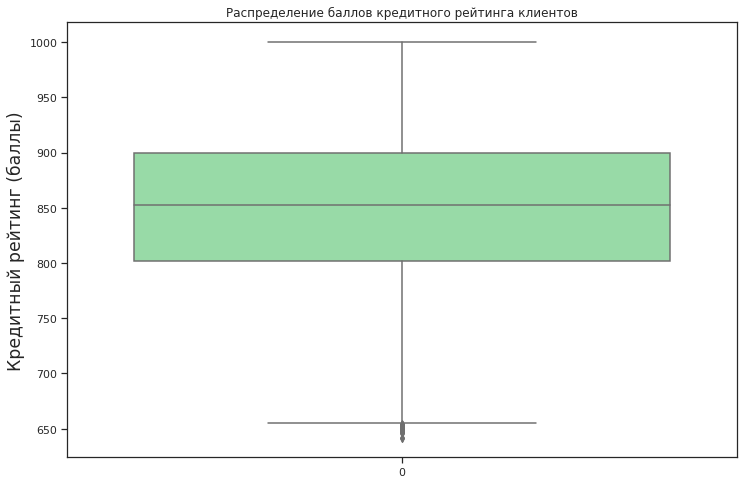

In [19]:
# Построим boxplot для визуализации распределения, квартилей и выбросов
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.boxplot(data = df['score'], palette=['g'])
plt.ylabel('Кредитный рейтинг (баллы)', size='x-large')
plt.title('Распределение баллов кредитного рейтинга клиентов');

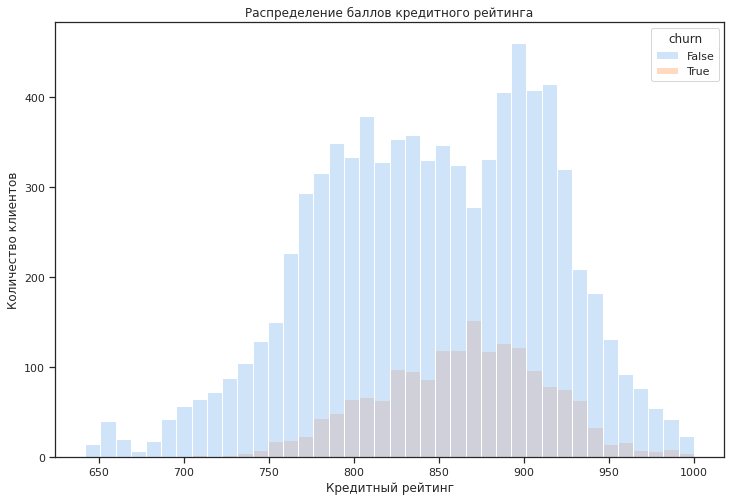

In [20]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.histplot(data=df, x='score', hue='churn')
plt.ylabel('Количество клиентов')
plt.xlabel('Кредитный рейтинг')
plt.title('Распределение баллов кредитного рейтинга');

Шкала НБКИ оценивает ПКР (персональный кредитный рейтинг) следующим образом:
- Низкий 1-632
- Средний 633-860
- Высокий 861-978
- Очень высокий 979-999

Из описательной статистики и графика видно мы можем сделать следующий вывод:
- Медианное значение кредитного рейтинга - 853 (высокий), больше 50% клиентов имеются высокий и очень высокий кредитный рейтинг.
- Минимальное значение в датасете - 642 (средний).
- Клиенты с низким кредитным рейтингом отсутствуют в датасете.

#### Анализ распределения клиентов по городам. <a id="#city"></a> 

In [21]:
# Посчитаем распределение клиентов по городам
city_counts = df['city'].value_counts()
city_counts

Ярославль    5888
Рыбинск      2694
Ростов       1417
Name: city, dtype: int64

In [22]:
# Визулизируем полученные данные
fig = go.Figure()
fig = px.pie(city_counts, values=city_counts,
             names=['Ярославль', 'Рыбинск', 'Ростов'],
             title='Диаграмма распределения клиентов по городам',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hole=0.2)
fig.show()

Вывод: 5888 (58,9%) клиентов из г. Ярославь, 2695 (27%) из г. Рыбинск, 1417(14,2%) из г. Ростов.

#### Распределение клиентов по полу. <a id="#gender"></a>

In [23]:
# Посчитаем распределение клиентов по полу
sex_counts = df['gender'].value_counts()
sex_counts

М    5005
Ж    4994
Name: gender, dtype: int64

In [24]:
# Визулизируем полученные данные
fig = go.Figure()
fig = px.pie(sex_counts, values=sex_counts,
             names=['М', 'Ж'],
             title='Диаграмма распределения клиентов по полу',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hole=0.2)
fig.show()

Вывод: клиенты распределены поровну.

#### Распределение клиентов по возрасту. <a id="#age"></a> 

In [25]:
# Выведем описательную статистику по столбцу age
df['age'].describe()

count    9973.000000
mean       42.730773
std        12.175166
min        18.000000
25%        33.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

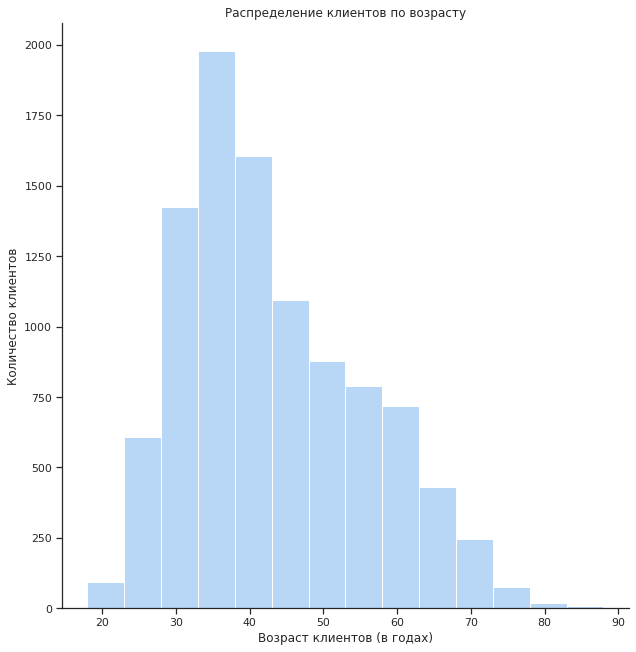

In [26]:
# Визулизируем полученные данные
sns.set_theme(style="ticks", palette="pastel")
sns.displot(data = df['age'], binwidth=5, height=9)
plt.ylabel('Количество клиентов')
plt.xlabel('Возраст клиентов (в годах)')
plt.title('Распределение клиентов по возрасту');

Из полученных данных можно сделать вывод:
- Медианный возраст клиента - 40 лет, минимальный вовзраст - 18 лет, средний - 42 года, максимальный - 86 лет.
- Больше 50% клиентов старше 40 лет, 75% клиентов моложе 51 года.

#### Распределение клиентов по баллам собственности. <a id="#equity"></a> 

In [27]:
# Выведем описательную статистику по столбцу equity
df['equity'].describe()

count    9999.000000
mean        2.627563
std         1.980931
min         0.000000
25%         0.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: equity, dtype: float64

In [28]:
# Создадим сводную таблицу, посчитаем клиентов в разрезе по баллам собственности
equity_pivot = df.pivot_table(index=['equity'], values=['user_id'], aggfunc='count').sort_values(by='user_id', ascending=False)
equity_pivot.columns = ['count']
equity_pivot = equity_pivot.reset_index()
equity_pivot

equity  count
0       0   2592
1       5   1918
2       4   1850
3       3   1542
4       2   1052
5       1    774
6       6    161
7       7     80
8       8     17
9       9     13

In [29]:
#Визуализируем полученные данные
fig = (px.bar(equity_pivot, x='equity', y='count', text ='count', 
              color='equity', color_discrete_sequence=px.colors.qualitative.Pastel))
fig.update_layout(showlegend=False,
                  title='Распределение клиентов по баллам собственности',
                  xaxis_title='Баллы собственности (от 0 до 9)',
                  yaxis_title='Количество клиентов')
fig.show()

Из вышеприведенных данных видно, что:
- 25.9% клиентов не имеют баллов собственности, 19.2% имеют 5 баллов, 18.5% - 4 балла.
- Медианное значение - 3 балла, максимальное - 9 баллов, 75% клиентов имеют 4 балла и ниже.

#### Распределение клиентов по остатку на текущем счете. <a id="#balance"></a> 

В ходе предобраотки данных мы установили, что по тем или иным причинах в датасете отсутствует информацию по текущему остатку на счете у почти 23% клиентов. Однако, информация по остаткам на счетам по остальным 77% так или иначе может быть полезна для дальнейшего исследования.

In [30]:
# Создадим переменную без пропущенных значений в столбце balance
balance_counts = df.dropna(subset=['balance'])

In [31]:
# Выведем описательную статистику по столбцу balance
balance_counts['balance'].describe().round()

count         7705.0
mean        827794.0
std        1980614.0
min              0.0
25%         295554.0
50%         524272.0
75%         980706.0
max      119113552.0
Name: balance, dtype: float64

Мы обнаружили аномальное максимальное значение текущего остатка - 119113552.0, уберем аномалии при визуализации данных.

In [32]:
# Ограничим текущий максималньый остаток на счете 2,5 млн
balance_counts = balance_counts.query('0 <= balance <= 2500000')

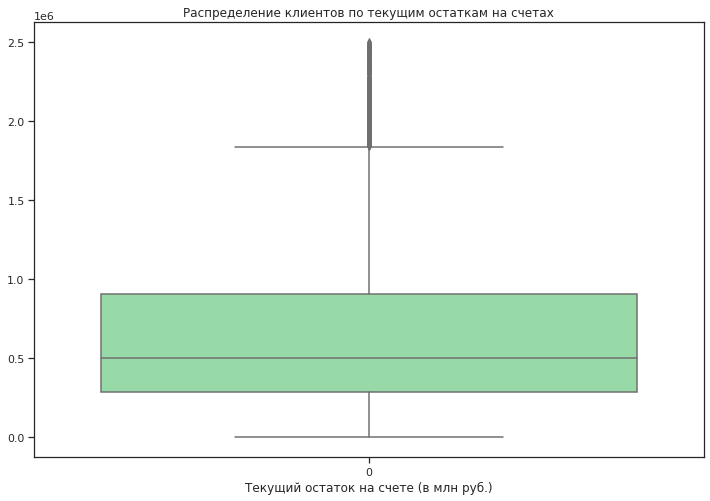

In [33]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data = balance_counts['balance'], palette=['g'])
plt.xlabel('Текущий остаток на счете (в млн руб.)')
plt.title('Распределение клиентов по текущим остаткам на счетах');

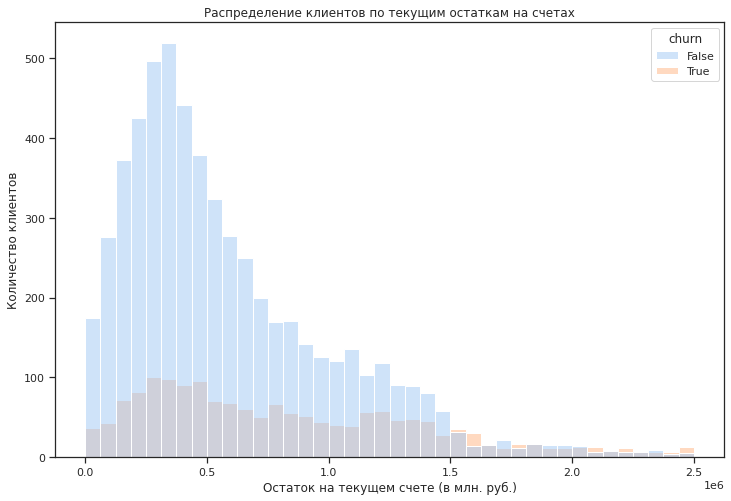

In [34]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.histplot(data=balance_counts, x='balance', hue='churn')
plt.ylabel('Количество клиентов')
plt.xlabel('Остаток на текущем счете (в млн. руб.)')
plt.title('Распределение клиентов по текущим остаткам на счетах');

Медианное значение текущего остатка - 524272 руб., минимальное - 0 руб., больше 25% клиентов имеют на счете больше 295554 руб., 75% клиентов имеются текущий остаток ниже 980706 руб.

#### Распределение клиентов по количеству подключенных продуктов банка. <a id="#products"></a> 

In [35]:
# Построим сводную таблицу с подсчетом количества продуктов 
products_pivot = (df.pivot_table(index=['products'], values=['user_id'], aggfunc='count')
                  .sort_values(by='products').reset_index())
products_pivot

products  user_id
0         1     3341
1         2     5126
2         3     1039
3         4      474
4         5       19

Обнаружен 1 пользователь с 0 подключенных продуктов, видимо, у него они еще не открыты, удалим его из нашей таблицы.

In [36]:
products_pivot['ratio'] = ((products_pivot['user_id']/10000)*100).round(2)
products_pivot.columns = ['products', 'count', 'ratio']
products_pivot

products  count  ratio
0         1   3341  33.41
1         2   5126  51.26
2         3   1039  10.39
3         4    474   4.74
4         5     19   0.19

In [37]:
sns.set(rc={'figure.figsize':(15, 9)})
fig = (px.bar(products_pivot, x='products', y='count', text='ratio', color_discrete_sequence=px.colors.qualitative.Pastel))
fig.update_layout(showlegend=False,
                  title='Распределение клиентов по количеству подключенных продуктов',
                  xaxis_title='Количество подключенных продуктов',
                  yaxis_title='Количество клиентов')
fig.show()

Вывод: из вышеприведенных данных следует, что у большинства клиентов (5126 чел, 51%) подключено 2 банковских продукта, у 3341 (33%) один продукт, у 1039 (10%) три продукта, и у остальных 4 или 5 продуктов.

#### Распределение пользователей по наличию кредитных карт. <a id="#credit"></a> 

In [38]:
# Посчитаем количество клиентов по наличию кредитных карт
сс_counts = df['credit_card'].value_counts()
сс_counts

True     6804
False    3195
Name: credit_card, dtype: int64

In [39]:
# Визулизируем полученные данные
fig = go.Figure()
fig = px.pie(сс_counts, values=сс_counts,
             names=['Есть карта', 'Нет карты'],
             title='Диаграмма распределения клиентов по наличию кредитной карты',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hole=0.2)
fig.show()

У 68% клиентов в нашем датасете есть кредитная карта.

#### Распределение активных и неактивных клиентов. <a id="#activity"></a> 

In [40]:
# Посчитаем количество клиентов по признаку активен/неактивен
active_counts = df['last_activity'].value_counts()
active_counts

True     5235
False    4764
Name: last_activity, dtype: int64

In [41]:
# Визулизируем полученные данные
fig = go.Figure()
fig = px.pie(active_counts, values=active_counts,
             names=['Активный', 'Неактивный'],
             title='Диаграмма распределения клиентов по признаку активности',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hole=0.2)
fig.show()

52,3% представленных клиентов активные, т.е. совершали какое-либо действие в течение недавнего времени.

#### Распределение клиентов по оценочному доходу. <a id="#salary"></a> 

In [42]:
# Выведем описательную статистику по столбцу est_salary
df['est_salary'].describe().round()

count       9999.0
mean      147879.0
std       139390.0
min         2546.0
25%        75252.0
50%       119662.0
75%       174501.0
max      1395064.0
Name: est_salary, dtype: float64

In [43]:
# Ограничим оценчный доход на счете 0,5 млн
est_salary_counts = df.query('0 <= est_salary <= 500000')

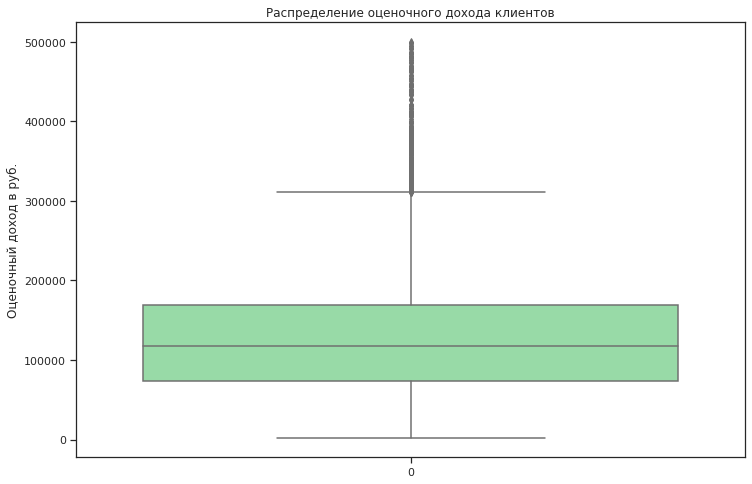

In [44]:
# Визулизируем полученные данные
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.boxplot(data = est_salary_counts['est_salary'], palette=['g'])
plt.ylabel('Оценочный доход в руб.')
plt.title('Распределение оценочного дохода клиентов');

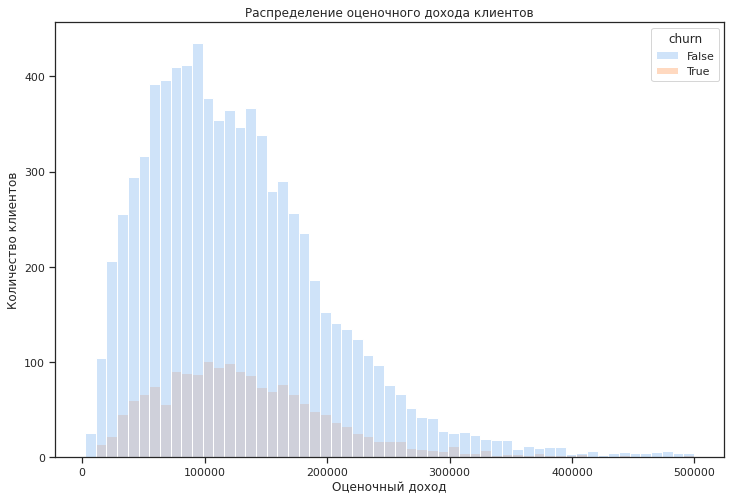

In [45]:
# Построим гистограмму в разрезе признака оттока
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.histplot(data=est_salary_counts, x='est_salary', hue='churn')
plt.ylabel('Количество клиентов')
plt.xlabel('Оценочный доход')
plt.title('Распределение оценочного дохода клиентов');

Вывод: медианный оценочный доход клиента составляет 119658 руб., минимальный - 2546 руб., 75% клиентов имеются оценочный доход меньше 174501 руб. 

#### Распределение по признаку оттока. <a id="#salary"></a> 

In [46]:
churn_counts = df['churn'].value_counts()
churn_counts

False    8180
True     1819
Name: churn, dtype: int64

In [47]:
fig = go.Figure()
fig = px.pie(churn_counts, values=churn_counts,
             names=['Отсутствует', 'Присутствует'],
             title='Диаграмма распределения клиентов по признаку оттока',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hole=0.2)
fig.show()

18.2% клиентов в датафрейме имеют признак оттока, т.е. закрыли свои счета, 81,8% все еще являются клиентами банка.

### Корреляционный анализ данных. <a id="#corr"></a> 

Для корреляционного анализа нам необходимо применить one-hot кодирование при помощи pandas.get_dummies, чтобы посмотреть корреляции наших числовых показателей с категоральными переменными (пол, город).

In [48]:
correlation_df = pd.get_dummies(df)
correlation_df.sample(10)

user_id  score   age  equity     balance  products  credit_card  \
2164   173500  780.0  47.0       2   226670.22         2         True   
3436   180088  943.0  26.0       0         NaN         1         True   
8592   118985  827.0  29.0       0   152081.74         2        False   
4793   177684  897.0  29.0       5  1240653.26         2        False   
5078   180622  825.0  39.0       2   306627.97         2         True   
9239   226963  760.0  34.0       3  1207351.69         3         True   
2151   219441  913.0  57.0       5  1295417.19         2        False   
7167   197504  829.0  25.0       3   159322.16         2         True   
9655   154451  934.0  46.0       5  1464834.59         4        False   
8138   221630  839.0  36.0       5  1007390.14         2        False   

      last_activity  est_salary  churn  city_Ростов  city_Рыбинск  \
2164          False   131894.54  False            0             0   
3436           True   114124.73  False            0             0   
8592           True    82600.08   True            1             0   
4793           True   150197.79   True            0             1   
5078          False   194956.16   True            1             0   
9239          False    47067.22   True            0             1   
2151          False    57853.30  False            0             1   
7167          False    46933.21  False            0             0   
9655           True   161508.58   True            0             0   
8138           True   177398.76  False            0             0   

      city_Ярославль  gender_Ж  gender_М  
2164               1         0         1  
3436               1         1         0  
8592               0         1         0  
4793               0         0         1  
5078               0         0         1  
9239               0         1         0  
2151               0         0         1  
7167               1         0         1  
9655               1         0         1  
8138               1         0         1

In [49]:
# Удалим лишний столбец с полом, 0 будет Ж, 1 - М
correlation_df = correlation_df.drop(['gender_Ж'], axis=1)
# Переименуем столбцы
correlation_df = correlation_df.rename(columns={'city_Ростов': 'city_rostov',
                                                'city_Рыбинск': 'city_rybinsk',
                                                'city_Ярославль':'city_yaroslavl',
                                                'gender_М':'gender'})
correlation_df.sample(10)

user_id  score   age  equity     balance  products  credit_card  \
9012   152499  835.0  44.0       5  1158366.22         1         True   
1655   137101  766.0  54.0       3   961827.01         3         True   
8458   158098  855.0  25.0       4   142991.11         2        False   
8829   154997  863.0  53.0       4  1061711.06         2         True   
1735   179892  846.0  62.0       4   356362.92         4        False   
9334   205732  853.0  67.0       2   547492.84         2        False   
7568   179418  828.0  27.0       3   150563.65         2         True   
360    176772  854.0  29.0       5   393070.37         1         True   
5005   215707  908.0  34.0       5  1236082.35         2        False   
1387   225062  848.0  67.0       4  1572533.44         3         True   

      last_activity  est_salary  churn  city_rostov  city_rybinsk  \
9012           True    65954.74  False            0             1   
1655          False    57092.64  False            0             0   
8458           True    57800.15   True            0             1   
8829           True    64760.50  False            0             1   
1735           True    58992.85   True            0             1   
9334           True    41123.25  False            0             0   
7568          False    40834.33  False            1             0   
360           False   105618.90  False            0             0   
5005           True   192243.61   True            0             0   
1387          False    38153.59  False            0             0   

      city_yaroslavl  gender  
9012               0       1  
1655               1       0  
8458               0       1  
8829               0       1  
1735               0       1  
9334               1       0  
7568               0       0  
360                1       0  
5005               1       0  
1387               1       1

In [50]:
# Удалим столбец с user_id, т.к. он не нужен при расчете корреляций
correlation_df = correlation_df.drop(['user_id'], axis=1)
# Подсчитаем коэффициент корреляций для наших столбцов
correlation_df = correlation_df.corr()
correlation_df

score       age    equity   balance  products  credit_card  \
score           1.000000 -0.012339  0.064103  0.235812 -0.003708    -0.094503   
age            -0.012339  1.000000  0.020581  0.069745  0.017900    -0.122761   
equity          0.064103  0.020581  1.000000  0.164126  0.432235    -0.167497   
balance         0.235812  0.069745  0.164126  1.000000  0.075684    -0.059253   
products       -0.003708  0.017900  0.432235  0.075684  1.000000    -0.251831   
credit_card    -0.094503 -0.122761 -0.167497 -0.059253 -0.251831     1.000000   
last_activity  -0.031004 -0.007849 -0.001950  0.025004  0.036905    -0.033603   
est_salary      0.164049 -0.039354 -0.171965  0.339622 -0.118299     0.035432   
churn           0.105634 -0.050463  0.270581  0.085577  0.301616    -0.130524   
city_rostov    -0.037572  0.047128  0.036300 -0.035805 -0.006223    -0.098534   
city_rybinsk   -0.000609  0.028978 -0.005651 -0.034697 -0.042259    -0.049880   
city_yaroslavl  0.027180 -0.059549 -0.020634  0.057342  0.042515     0.114816   
gender          0.012429 -0.212628 -0.021604  0.051711 -0.022916     0.126223   

                last_activity  est_salary     churn  city_rostov  \
score               -0.031004    0.164049  0.105634    -0.037572   
age                 -0.007849   -0.039354 -0.050463     0.047128   
equity              -0.001950   -0.171965  0.270581     0.036300   
balance              0.025004    0.339622  0.085577    -0.035805   
products             0.036905   -0.118299  0.301616    -0.006223   
credit_card         -0.033603    0.035432 -0.130524    -0.098534   
last_activity        1.000000    0.002947  0.169037     0.006962   
est_salary           0.002947    1.000000  0.001460    -0.106101   
churn                0.169037    0.001460  1.000000     0.006112   
city_rostov          0.006962   -0.106101  0.006112     1.000000   
city_rybinsk         0.048993   -0.057300 -0.031605    -0.246763   
city_yaroslavl      -0.049111    0.126870  0.024165    -0.486296   
gender              -0.013768    0.082295  0.141287    -0.015072   

                city_rybinsk  city_yaroslavl    gender  
score              -0.000609        0.027180  0.012429  
age                 0.028978       -0.059549 -0.212628  
equity             -0.005651       -0.020634 -0.021604  
balance            -0.034697        0.057342  0.051711  
products           -0.042259        0.042515 -0.022916  
credit_card        -0.049880        0.114816  0.126223  
last_activity       0.048993       -0.049111 -0.013768  
est_salary         -0.057300        0.126870  0.082295  
churn              -0.031605        0.024165  0.141287  
city_rostov        -0.246763       -0.486296 -0.015072  
city_rybinsk        1.000000       -0.726773 -0.015997  
city_yaroslavl     -0.726773        1.000000  0.025107  
gender             -0.015997        0.025107  1.000000

In [51]:
# Визуализируем полученные данные с помощью интерактивной тепловой карты
fig = px.imshow(correlation_df, color_continuous_scale='viridis', width=1000, height=1500, aspect='equal')
fig.update_xaxes(side='top')
fig.update_layout(title='Тепловая карта коэффициента корреляции')
fig.show()

Вывод:
- Между признаками equity и churn имеется слабая положительная корреляция, чем больше баллов собственности, тем выше шанс оттока клиента.
- Между признаками products и churn имеется слабая положительная корреляция, чем больше у клиента открытых продуктов, тем выше шанс оттока клиента.
- Есть слабые положительные коррреляции между score и balance, balance и est_salary, и equity и products. Это логично, т.к. тем выше кредитный рейтинг, тем вероятнее, что у клиента выше доход, чем выше у клиента доход, тем вероятнее, что у него будет больший остаток на текущем счете и ему будет нужно больше банковских продуктов.
- Сильной корреляции между переменными (>0.8) найдено не было, как положительной, так и отрицательной.

## Проверка гипотез. <a id="#hyp"></a> 

###  Гипотеза о наличии различия между доходами отточных клиентов и оставшихся. <a id="#hyp_1"></a> 

In [52]:
# Создадим переменные с признаком оттока и без
df_churn_1 = df.query('churn == 1')
df_no_churn = df.query('churn == 0')
# Проверим, посчитав кол-во столбцов
display(len(df_churn_1))
display(len(df_no_churn))

1819

8180

Количество строк соответствует нашим данным при анализе распределения.

Объявим гипотезы:
- **H0**: Различие доходов между клиентами с признаком оттока и без статистически незначимо.
- **H1**: Различие доходов между клиентами с признаком оттока и без статистически значимо.

In [53]:
# Проведем T-тест
alpha = 0.01 # задаем уровень стат. значимости
results = stats.ttest_ind(df_churn_1['est_salary'], 
                       df_no_churn['est_salary'],
                       alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 0.44196822165908295
Не удалось отвергнуть нулевую гипотезу


Различие доходов между клиентами с признаком оттока и без статистически незначимо.

### Гипотеза о наличии связи между открытыми продуктами и признаком оттока. <a id="#hyp_2"></a> 

В ходе анализа корреляции наших переменных была найдена вазимосвязь (коэф. корр. = 0.301616) между признаком оттока и количеством открытых продуктов. Протестируем гипотезу о статистической значимости различий между количеством открытых продуктов и оттоком.

Объявим гипотезы:
- **H0**: Различие между количеством открытых продуктов и признаком оттока статистически незначимо.
- **H1**: Различие между количеством открытых продуктов и признаком оттока статистически значимо.

In [54]:
# Проведем T-тест
alpha = 0.01 # задаем уровень стат. значимости
results = stats.ttest_ind(df_churn_1['products'], 
                       df_no_churn['products'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 2.3430165753532827e-209
Отвергаем нулевую гипотезу


Мы нашли статистическую взимосвязь между количеством открытых продуктов и признаком оттока.

<div class="alert alert-info"> <b>Комментарий студента:</b> У нас есть два распределения: распределение значений с признаком оттока и без. ttest_ind проверяет проверяет равенство средних значений двух независимых ген. совокупностей. Мы знаем, что клиенты с признаком оттока и без - разные клиенты. Соответственно, можем использовать ttest_ind для проверки равенства ср. значений. </div>

## Формирование сегментов клиентов и их анализ. <a id="#seg"></a> 

Для сегментации необходимо рассмотреть метрики в разрезе отточных и не отточных клиентов. Мы уже установили связь между открытыми продуктами и признаком оттока, также в ходе корреляционного анализа была найдена слабая положительная связь между количество баллов собственности и оттоком. Необходимо посмотреть и на другие данные клиентов в разрезе оттока, чтобы сегментировать клиентов.

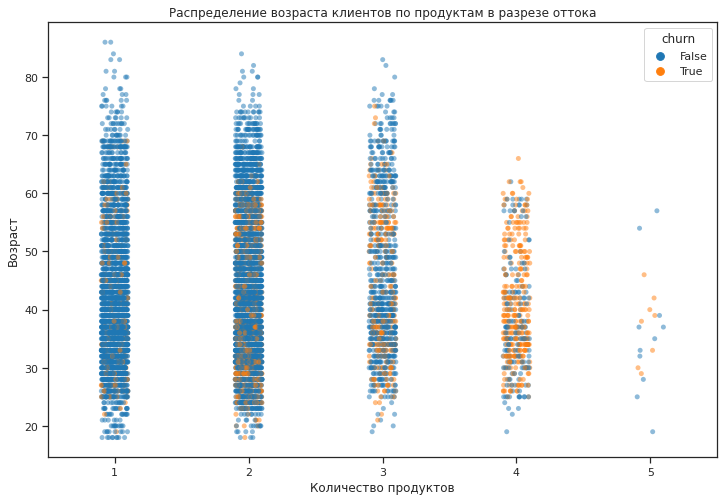

In [55]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='tab10')
ax = sns.stripplot(data=df, x='products', y='age', hue='churn', alpha=0.5)
plt.ylabel('Возраст')
plt.xlabel('Количество продуктов')
plt.title('Распределение возраста клиентов по продуктам в разрезе оттока');

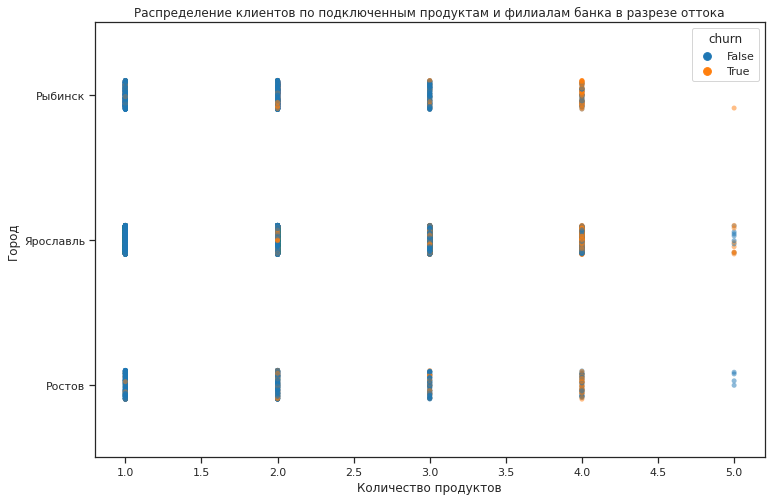

In [56]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='tab10')
ax = sns.stripplot(data=df, x='products', y='city', hue='churn', alpha=0.5);
plt.ylabel('Город')
plt.xlabel('Количество продуктов')
plt.title('Распределение клиентов по подключенным продуктам и филиалам банка в разрезе оттока');

В разрезе городов не наблюдаетя каких-либо связей, значит, проблема не связана с каким-то одноим филиалом.

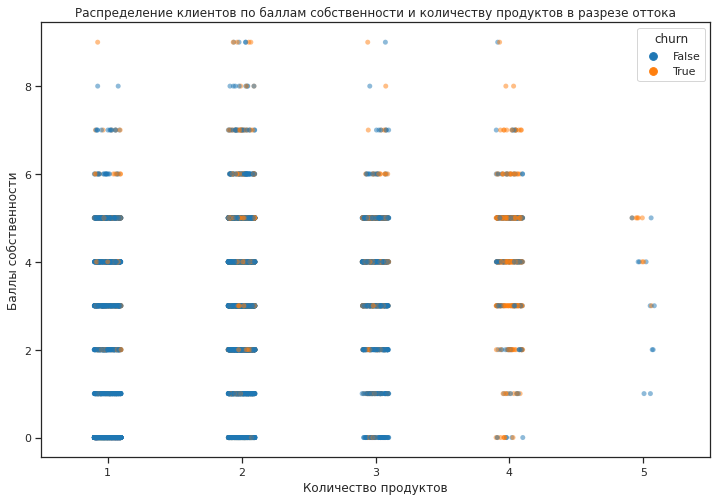

In [57]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='tab10')
ax = sns.stripplot(data=df, x='products', y='equity', hue='churn', alpha=0.5)
plt.ylabel('Баллы собственности')
plt.xlabel('Количество продуктов')
plt.title('Распределение клиентов по баллам собственности и количеству продуктов в разрезе оттока');

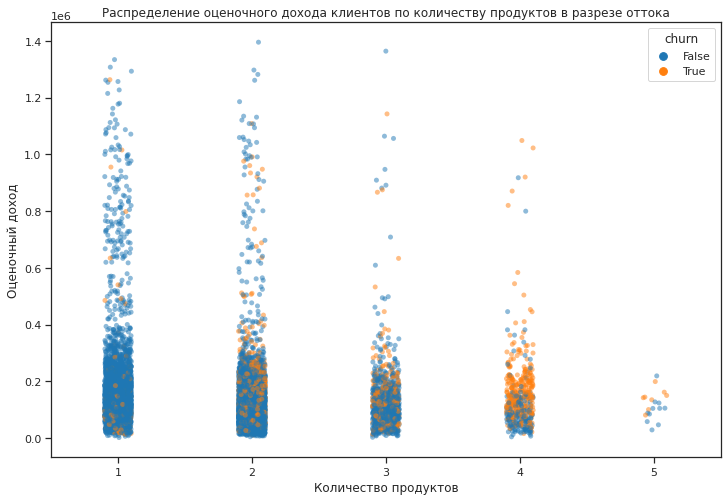

In [58]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='tab10')
ax = sns.stripplot(data=df, x='products', y='est_salary', hue='churn', alpha=0.5)
plt.ylabel('Оценочный доход')
plt.xlabel('Количество продуктов')
plt.title('Распределение оценочного дохода клиентов по количеству продуктов в разрезе оттока');

Однозначно можно сделать вывод, что клиенты с 4 продуктами - самые отточные, а клиенты с 1 продуктом - наиболее лояльные.
Для сегментации клиентов с двумя и тремя продуктами нужно установить дополнительные связи.

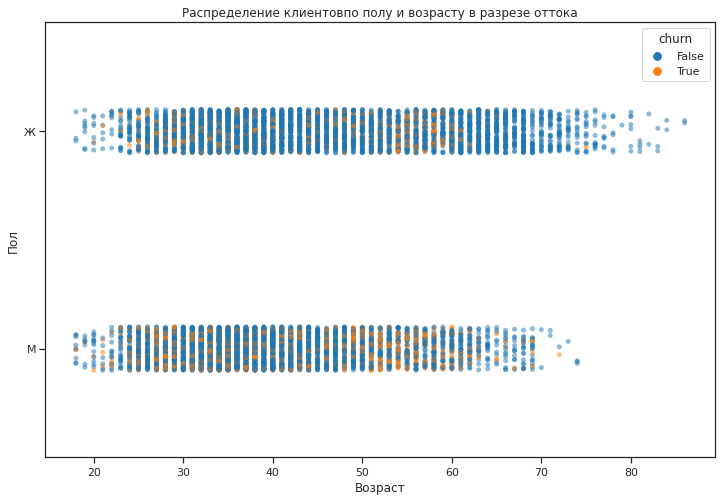

In [59]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='tab10')
ax = sns.stripplot(data=df, x='age', y='gender', hue='churn', alpha=0.5);
plt.ylabel('Пол')
plt.xlabel('Возраст')
plt.title('Распределение клиентовпо полу и возрасту в разрезе оттока');

Из графика выше можно сделать вывод, что наиболее отточная категория: мужчины и женщины 50-60 лет. Также отточность наблюдается у молодых людей до 30 лет.

Исходя из ранее привденного анализа наших данных можно точно сказать, что:
- Нам неинтересны клиенты с 0 или 1 баллом собственности, они лояльные.
- Нам неинтересны клиенты, у которых открыт один продукт, они лояльные.

Итого, можно попытаться разделить интересующих нас клиентов с риском оттока на следующие сегменты:
- Первый сегмент: клиенты до 30 лет с двумя и более банковскими продуктами и с баллами собственности выше или равные 2.
- Второй сегмент: клиенты 30-49 лет с двумя и более банковскими продуктами и с баллами собственности выше или равные 4 (равное 4 и выше, т.к. 30-49 наиболее лояльная и многочисленная группа, соответственно, баллы собственности нужно взять повыше, иначе соотношение к оттоку будет достаточно невысокое).
- Третий сегмент: клиенты 50-60 лет с двумя и более банковскими продуктами и с баллами собственности выше или равные 2 (наиболее отточная группа по возрасту).

In [60]:
segment_1 = df.query('age < 30 & products >=2 & equity >=2')
segment_1

user_id  score       city gender   age  equity     balance  products  \
13     166357  837.0    Рыбинск      Ж  28.0       4   302249.22         2   
33     125478  786.0     Ростов      Ж  27.0       3   448062.52         3   
38     220711  794.0     Ростов      Ж  26.0       2   147487.39         2   
53     208625  831.0     Ростов      М  28.0       2    75005.22         2   
88     210088  894.0  Ярославль      М  29.0       3   786911.18         2   
...       ...    ...        ...    ...   ...     ...         ...       ...   
9882   202619  756.0    Рыбинск      М  26.0       5   311073.33         3   
9891   161917  963.0  Ярославль      М  27.0       4  4028889.42         2   
9931   222683  986.0     Ростов      Ж  28.0       3   609468.20         2   
9972   150126  834.0     Ростов      М  27.0       4   192776.27         2   
9978   218170  841.0  Ярославль      М  29.0       2   235287.10         2   

      credit_card  last_activity  est_salary  churn  
13          False           True    30950.94  False  
33           True           True    37607.67  False  
38          False           True    24912.88  False  
53           True          False    70283.32  False  
88           True           True    99022.74   True  
...           ...            ...         ...    ...  
9882         True          False    17597.52  False  
9891        False           True   376158.61   True  
9931         True          False    29831.21  False  
9972        False           True    26570.39  False  
9978         True           True   137494.06   True  

[620 rows x 12 columns]

In [61]:
# Посчитаем уровень оттока в первом сегменте
churn_level_1 = segment_1.pivot_table(index='churn', values = 'user_id', aggfunc='count').reset_index()
print('Уровень оттока клиентов первого сегмента:', 
      (churn_level_1.loc[1, 'user_id']/len(segment_1)).round(2)*100, '%')
print('Количество клиентов первого сегмента:', len(segment_1))

Уровень оттока клиентов первого сегмента: 33.0 %
Количество клиентов первого сегмента: 620


In [62]:
segment_2 = df.query('age >= 30 & age < 50 & products >=2 & equity >=4')
segment_2

user_id  score       city gender   age  equity     balance  products  \
1      146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
7      218868  825.0  Ярославль      Ж  38.0       4   458145.40         2   
14     172138  815.0  Ярославль      М  35.0       5   547499.87         2   
18     136651  876.0  Ярославль      М  40.0       5  2307947.36         2   
31     152670  806.0     Ростов      Ж  36.0       5   377460.32         2   
...       ...    ...        ...    ...   ...     ...         ...       ...   
9968   167969  857.0  Ярославль      Ж  36.0       5   725371.47         2   
9970   175730  816.0    Рыбинск      М  36.0       4   477892.07         3   
9980   117291  779.0     Ростов      Ж  44.0       4   380025.17         2   
9981   154871  892.0    Рыбинск      М  39.0       5   636287.72         2   
9988   158678  889.0  Ярославль      М  35.0       4   880534.89         4   

      credit_card  last_activity  est_salary  churn  
1            True          False    86621.77  False  
7            True           True    68085.48  False  
14           True           True   105883.26  False  
18          False          False   287010.61  False  
31           True          False   102885.09  False  
...           ...            ...         ...    ...  
9968         True           True    57473.78  False  
9970         True          False    81100.60  False  
9980        False           True   155887.84  False  
9981        False           True   227288.27   True  
9988         True           True   126564.61  False  

[2023 rows x 12 columns]

In [63]:
# Посчитаем уровень оттока во втором сегменте
churn_level_2 = segment_2.pivot_table(index='churn', values = 'user_id', aggfunc='count').reset_index()
print('Уровень оттока клиентов второго сегмента:', 
      (churn_level_2.loc[1, 'user_id']/len(segment_2)).round(2)*100, '%')
print('Количество клиентов второго сегмента:', len(segment_2))

Уровень оттока клиентов второго сегмента: 30.0 %
Количество клиентов второго сегмента: 2023


In [64]:
segment_3 = df.query('age >= 50 & age <= 60 & products >=2 & equity >=2')
segment_3

user_id  score       city gender   age  equity     balance  products  \
3      225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
5      202305  856.0    Рыбинск      М  56.0       4   863687.24         3   
8      211686  923.0  Ярославль      М  54.0       5  1206337.87         2   
17     214277  793.0  Ярославль      М  53.0       3   627034.50         2   
41     206939  814.0    Рыбинск      М  56.0       2  1067536.40         2   
...       ...    ...        ...    ...   ...     ...         ...       ...   
9877   225431  830.0  Ярославль      М  53.0       4  1220272.89         2   
9887   167524  856.0  Ярославль      М  50.0       3   265390.36         2   
9944   205255  769.0  Ярославль      Ж  60.0       4  1409579.65         2   
9986   152986  822.0  Ярославль      М  58.0       5  1434857.91         2   
9999    96267  828.0    Рыбинск      Ж  58.0       3  1180886.70         4   

      credit_card  last_activity  est_salary  churn  
3           False           True   174423.53   True  
5            True          False   156619.80  False  
8            True          False   155371.79  False  
17           True          False   183430.19  False  
41           True          False    95563.19  False  
...           ...            ...         ...    ...  
9877         True          False    88456.17   True  
9887         True           True   154039.56   True  
9944         True           True    66316.67  False  
9986        False           True    83442.41   True  
9999        False           True    21422.37  False  

[1035 rows x 12 columns]

In [65]:
# Посчитаем уровень оттока в третьем сегменте
churn_level_3 = segment_3.pivot_table(index='churn', values = 'user_id', aggfunc='count').reset_index()
print('Уровень оттока клиентов третьего сегмента:', 
      (churn_level_3.loc[1, 'user_id']/len(segment_3)).round(2)*100, '%')
print('Количество клиентов третьего сегмента:', len(segment_3))

Уровень оттока клиентов третьего сегмента: 37.0 %
Количество клиентов третьего сегмента: 1035


Теперь добавим нашим сегментам столбец с признаком и объединим в один датафрейм.

In [66]:
# добавим новый столбец с признаком сегмента
segment_1.insert(0, 'seg', '1 сегмент')
segment_2.insert(0, 'seg', '2 сегмент')
segment_3.insert(0, 'seg', '3 сегмент')

In [67]:
# объединим датафреймы в один
frames = [segment_1, segment_2, segment_3]
joined_churn = pd.concat(frames)

In [68]:
# Удалим старый индекс
joined_churn = joined_churn.reset_index(drop=True)
joined_churn

seg  user_id  score       city gender   age  equity     balance  \
0     1 сегмент   166357  837.0    Рыбинск      Ж  28.0       4   302249.22   
1     1 сегмент   125478  786.0     Ростов      Ж  27.0       3   448062.52   
2     1 сегмент   220711  794.0     Ростов      Ж  26.0       2   147487.39   
3     1 сегмент   208625  831.0     Ростов      М  28.0       2    75005.22   
4     1 сегмент   210088  894.0  Ярославль      М  29.0       3   786911.18   
...         ...      ...    ...        ...    ...   ...     ...         ...   
3673  3 сегмент   225431  830.0  Ярославль      М  53.0       4  1220272.89   
3674  3 сегмент   167524  856.0  Ярославль      М  50.0       3   265390.36   
3675  3 сегмент   205255  769.0  Ярославль      Ж  60.0       4  1409579.65   
3676  3 сегмент   152986  822.0  Ярославль      М  58.0       5  1434857.91   
3677  3 сегмент    96267  828.0    Рыбинск      Ж  58.0       3  1180886.70   

      products  credit_card  last_activity  est_salary  churn  
0            2        False           True    30950.94  False  
1            3         True           True    37607.67  False  
2            2        False           True    24912.88  False  
3            2         True          False    70283.32  False  
4            2         True           True    99022.74   True  
...        ...          ...            ...         ...    ...  
3673         2         True          False    88456.17   True  
3674         2         True           True   154039.56   True  
3675         2         True           True    66316.67  False  
3676         2        False           True    83442.41   True  
3677         4        False           True    21422.37  False  

[3678 rows x 13 columns]

Готово, данные объеденены в один датафрейм. Можно приступать к визуализации и посмотреть как отток зависит от разных признаков в разрезе сегментов.

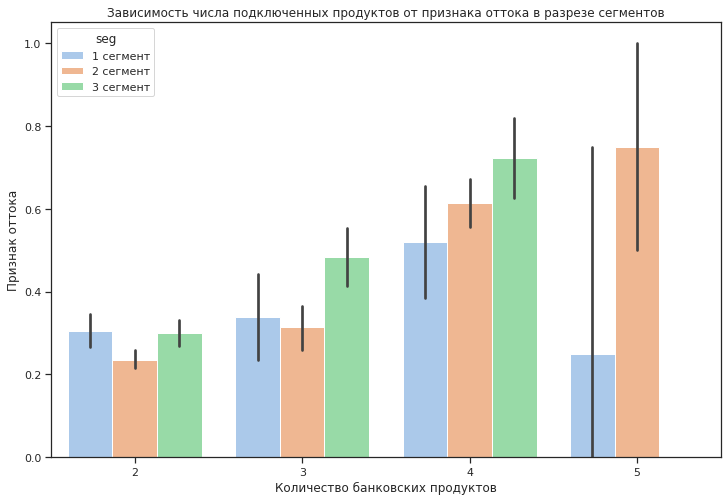

In [69]:
# Визуализируем данные
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.barplot(data=joined_churn, x='products', y='churn', hue='seg') 
plt.ylabel('Признак оттока')
plt.xlabel('Количество банковских продуктов')
plt.title('Зависимость числа подключенных продуктов от признака оттока в разрезе сегментов');

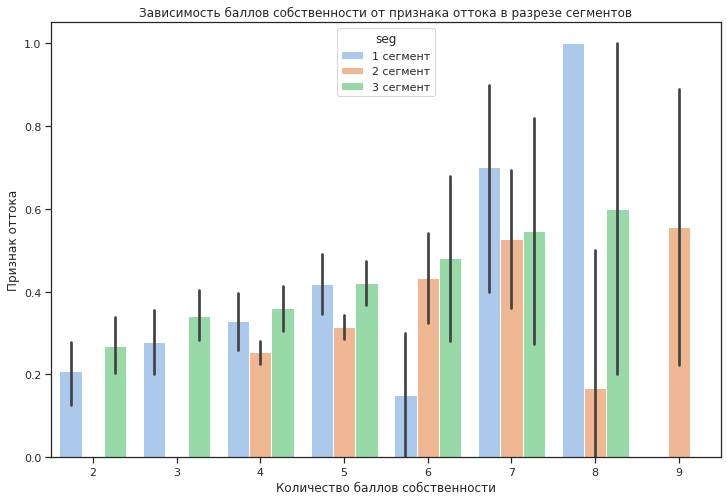

In [70]:
# Визуализируем данные
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.barplot(data=joined_churn, x='equity', y='churn', hue='seg') 
plt.ylabel('Признак оттока')
plt.xlabel('Количество баллов собственности')
plt.title('Зависимость баллов собственности от признака оттока в разрезе сегментов');

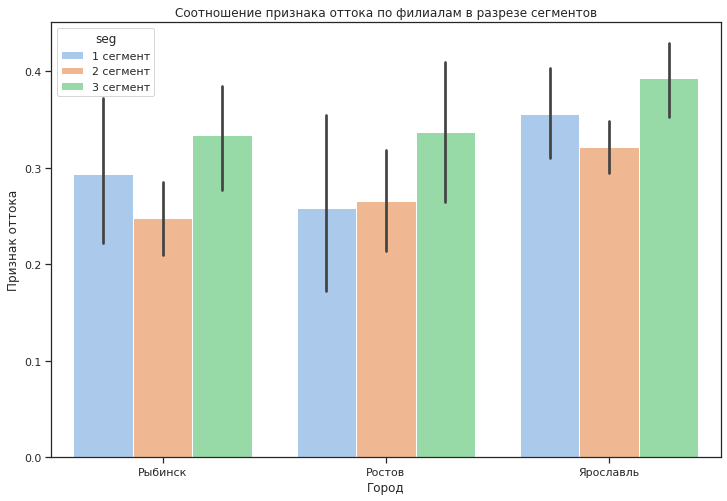

In [71]:
# Визуализируем данные
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.barplot(data=joined_churn, x='city', y='churn', hue='seg') 
plt.ylabel('Признак оттока')
plt.xlabel('Город')
plt.title('Соотношение признака оттока по филиалам в разрезе сегментов');

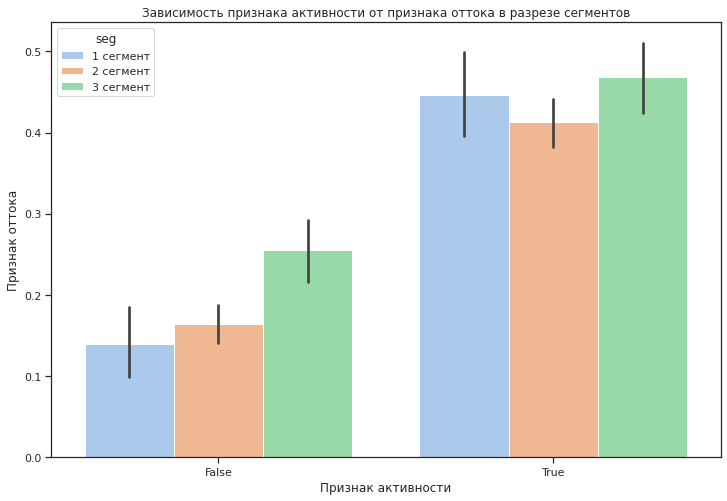

In [72]:
# Визуализируем данные
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.barplot(data=joined_churn, x='last_activity', y='churn', hue='seg') 
plt.ylabel('Признак оттока')
plt.xlabel('Признак активности')
plt.title('Зависимость признака активности от признака оттока в разрезе сегментов');

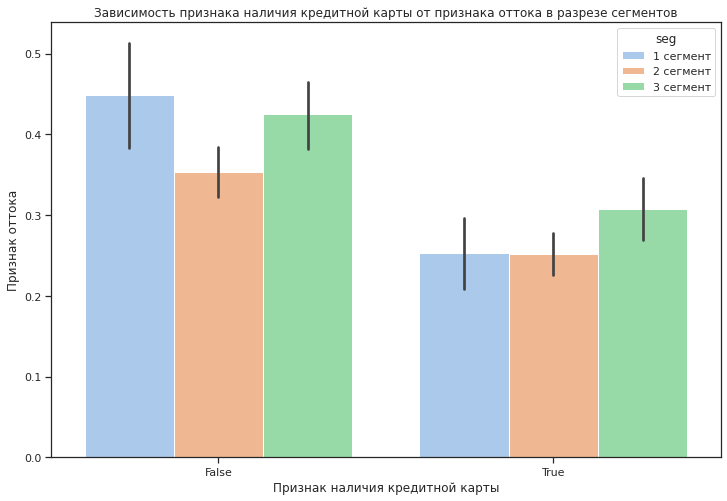

In [73]:
# Визуализируем данные
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_theme(style='ticks', palette='pastel')
sns.barplot(data=joined_churn, x='credit_card', y='churn', hue='seg') 
plt.ylabel('Признак оттока')
plt.xlabel('Признак наличия кредитной карты')
plt.title('Зависимость признака наличия кредитной карты от признака оттока в разрезе сегментов');

## Вывод.  <a id="#conclusion"></a> 

Общий вывод по результатам исследовательского анализа данных:
- У большинства клиентов высокий кредитный рейтинг.
- 5888 (58,9%) клиентов приходится на г. Ярославь, 2695 (27%) на г. Рыбинск, 1417(14,2%) на г. Ростов.
- Медианный возраст клиента - 40 лет, больше 50% клиентов старше 40 лет, 75% клиентов моложе 51 года.
- 25.9% клиентов не имеют баллов собственности, 75% клиентов имеют 4 балла и ниже.
- Медианное значение текущего остатка - 524272 руб., 75% клиентов из доступных нам данных имеют текущий остаток ниже 980706 руб. Данные могут быть искажены, т.к. по 23% клиентов нет информации.
- Большинство клиентов (51%) пользуются двумя банковскими продуктами.
- 68% клиентов имеют кредитную карточку.
- 52,3% клиентов активные.
- Медианный оценочный доход - 119658 руб.
- 81,8% клиентов не имеют признаков оттока, продолжают пользоваться продуктами банка.
- Между вышеназванными признаками нет сильной корреляционной зависимости.

Вывод по анализу корреляций признаков и наших гипотез:
- Найдена зависимость между баллами собственности и признаками оттока: чем больше баллов, тем больше показатели оттока.
- Найдена зависимость между количеством подключенных банковских продуктов и признаком оттока: чем больше у клиента банковских продуктов, тем выше шанс оттока.
- Найдена зависимость между текущим остатком на счете и признаками оттока: чем больше остаток, тем больше показатели оттока.

Клиенты были распределены по трем сегментам:
- Сегмент 1: клиенты до 30 лет с двумя и более банковскими продуктами и с баллами собственности выше или равные 2. Количество клиентов: 620 чел. Уровень оттока: 33%.
- Сегмент 2: клиенты 30-49 лет с двумя и более банковскими продуктами и с баллами собственности выше или равные 4. Количество клиентов: 2023 чел. Уровень оттока: 30%.
- Сегмент 3: клиенты 50-60 лет с двумя и более банковскими продуктами и с баллами собственности выше или равные 2. Количество клиентов: 1035. Уровент оттока: 37%.

**Общие рекомендации**:
- Наиболее высокий отток демонстририруют клиенты с 3 и более открытыми продуктами, приоритизировать работу по удержанию с этими id.
- Наиболее высокий отток в группе с 4 и более баллами собственности, приоритизировать работу по удержанию с этими id.
- Стоит обратить внимание на id с признаком активности, они более склонны к оттоку.
- Стоит обратить внимание клиентов с отсутствием кредитной карты, они более отточные.

В общем и целом самые отточные клиенты - это клиенты с большим набором банковских продуктов, вероятно, у них есть потребность, которую банк в данный момент не может закрыть, но которая имеется у крупных банков-конкурентов. Стоит подумать о создании комплексных продуктов для снижения показателей оттока.

**Рекомендация для первого сегмента**: Сегмент является наиболее малочисленным из представленных, его нужно приоритизировать в последнюю очередь. Вероятно, проблема в неконкурентноспособности текущих банковских услуг по сравнению с конкурентами. 

**Рекомендации для второго сегмента**: Id, отобранные из наиболее многочисленного и лояльного сегмента, приоритизировать во вторую очередь. Клиентов с высокими быллами собственности, скорее всего, не устраивают условия доходности банковских продуктов

**Рекомендации для третьего сегмента**: сегмент является наиболее проблемным и отточным, необходимо приоритизировать в первую очередь работу по удержанию клиентов. Клиенты сегмента обладают в среднем более высокими значениями баллов собственности и оценочного дохода. Возможно, их не устраивают действующие условия по доходности банковских продуктов, необходимо обратить на это внимание.